# Graviational Waves in Python
This notebook intends to showcase the basic functionality of various libraries for analysing gravitational waves in python

## PyCBC
PyCBC can be used to load, analyse and plot GW data. To start out we can print the catalog of events.

In [1]:
from pycbc import catalog

for merger_name in catalog.Catalog():
    print(merger_name)

/home/teunb/launch/ASTRO/gravitational-waves/.venv/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


GW200322_091133-v1
GW200316_215756-v1
GW200311_115853-v1
GW200308_173609-v1
GW200306_093714-v1
GW200302_015811-v1
GW200225_060421-v1
GW200224_222234-v1
GW200220_124850-v1
GW200220_061928-v1
GW200219_094415-v1
GW200216_220804-v1
GW200210_092254-v1
GW200209_085452-v1
GW200208_222617-v1
GW200208_130117-v1
GW200202_154313-v1
GW200129_065458-v1
GW200128_022011-v1
GW200115_042309-v2
GW200112_155838-v1
GW191230_180458-v1
GW191222_033537-v1
GW191219_163120-v1
GW191216_213338-v1
GW191215_223052-v1
GW191204_171526-v1
GW191204_110529-v1
GW191129_134029-v1
GW191127_050227-v1
GW191126_115259-v1
GW191113_071753-v1
GW191109_010717-v1
GW191105_143521-v1
GW191103_012549-v1


We can now pick one to load: "GW191204_110529-v1"

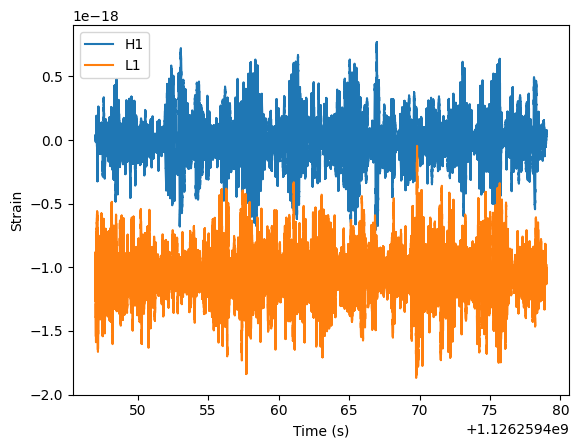

In [2]:
import matplotlib.pyplot as plt
m = catalog.Merger("GW150914")

# the raw data from the interferometers is stored in strain
ts_han = m.strain('H1') # for different detectors
ts_liv = m.strain('L1')

plt.plot(ts_han.sample_times, ts_han, label="H1")
plt.plot(ts_liv.sample_times, ts_liv, label="L1")
plt.legend()
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.show()

# Standard Preprocessing
PyCBC also has support for doing some standard denoising of the data. We focus on the L1 interferometer strain.

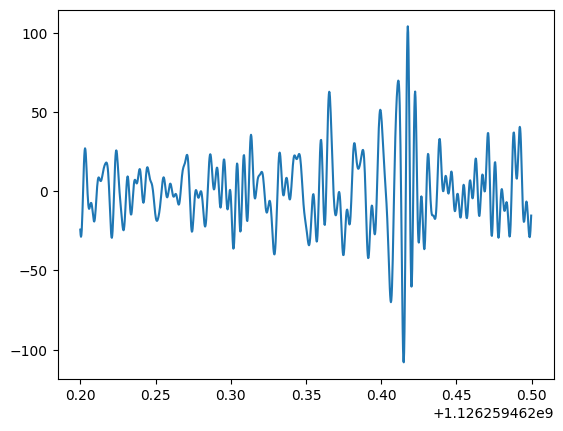

In [3]:
high_pass = ts_liv.highpass_fir(15, 512) # suppress low frequency noise

whitened = high_pass.whiten(4, 4) # Flatten Freq Response of PSD
bpsd = whitened.highpass_fir(30, 512).lowpass_fir(250, 512) # two more freq filters

# zoom in on event
event = bpsd.time_slice(m.time -0.2, m.time + 0.1)

plt.plot(event.sample_times, event)
plt.show()


# Visualization
Graviational waves are commonly visualized using a constant Q transform spectrogram.

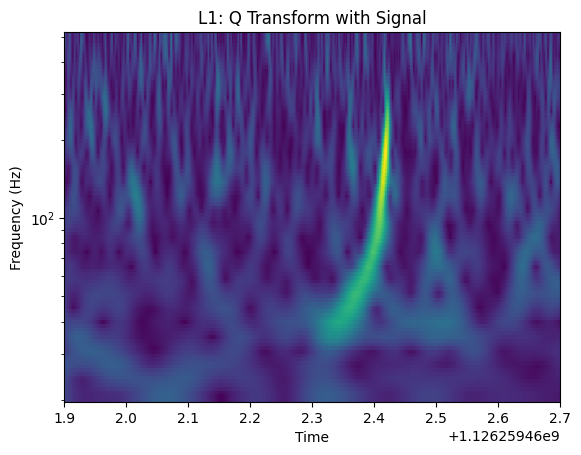

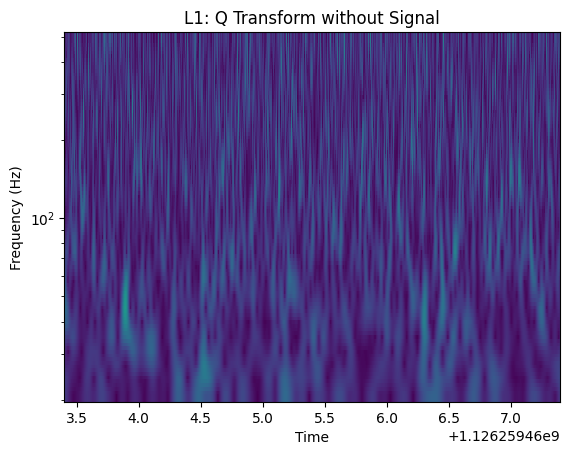

In [4]:
window = whitened.time_slice(m.time - 5, m.time + 5)
times, freqs, power = window.qtransform(.001, logfsteps=100, qrange=(8, 8), frange=(20,512))

plt.pcolormesh(times, freqs, power**0.5)
plt.xlim(m.time -0.5, m.time + 0.3)
plt.title("L1: Q Transform with Signal")
plt.yscale('log')
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.show()

plt.pcolormesh(times, freqs, power**0.5)
plt.xlim(m.time + 1, m.time + 5)
plt.title("L1: Q Transform without Signal")
plt.yscale('log')
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.show()

## Generating BBH signals
(stolen from doc :))

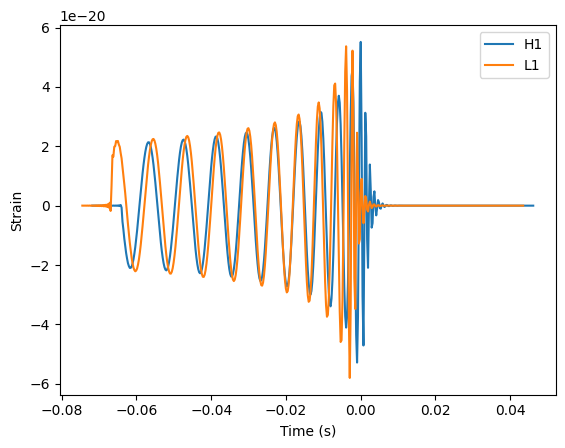

In [8]:
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector


apx = 'SEOBNRv4'
# NOTE: Inclination runs from 0 to pi, with poles at 0 and pi
#       coa_phase runs from 0 to 2 pi.
hp, hc = get_td_waveform(approximant=apx,
                         mass1=10,
                         mass2=10,
                         inclination=1.23,
                         coa_phase=2.45,
                         delta_t=1.0/4096,
                         f_lower=100)

det_h1 = Detector('H1')
det_l1 = Detector('L1')
det_v1 = Detector('V1')

# Choose a GPS end time, sky location, and polarization phase for the merger
# NOTE: Right ascension and polarization phase runs from 0 to 2pi
#       Declination runs from pi/2. to -pi/2 with the poles at pi/2. and -pi/2.
end_time = 0
declination = 0.5333
right_ascension = 2
polarization = 2.34
hp.start_time += end_time
hc.start_time += end_time

signal_h1 = det_h1.project_wave(hp, hc,  right_ascension, declination, polarization)
signal_l1 = det_l1.project_wave(hp, hc,  right_ascension, declination, polarization)

plt.plot(signal_h1.sample_times, signal_h1, label='H1')
plt.plot(signal_l1.sample_times, signal_l1, label='L1')

plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

torch.Size([3, 8192])


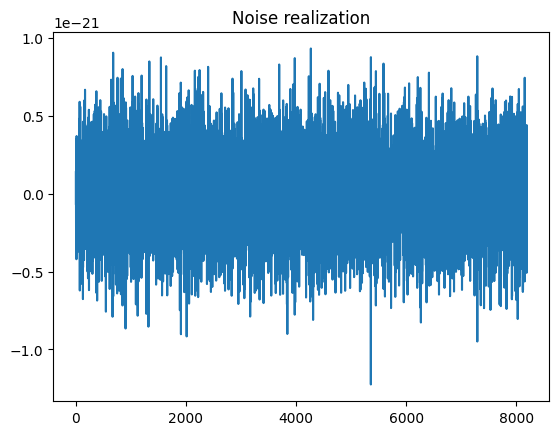

In [12]:
from torch import Tensor
from pycbc.noise import noise_from_psd
from pycbc.psd.analytical import aLIGOZeroDetHighPower
sample_duration = 2
num_samples = 3
flow = 30.0
delta_f = 1.0 / 16
flen = int(2048 / delta_f) + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, flow)

delta_t = 1.0 / 4096
tsamples = int(sample_duration * num_samples / delta_t)
ts = noise_from_psd(tsamples, delta_t, psd) # one long string of noise

ts =  Tensor(ts).reshape(num_samples, sample_duration * 4096)
print(ts.shape)
noise = ts[0]
plt.title("Noise realization")
plt.plot(noise)
plt.show()

torch.Size([8192])


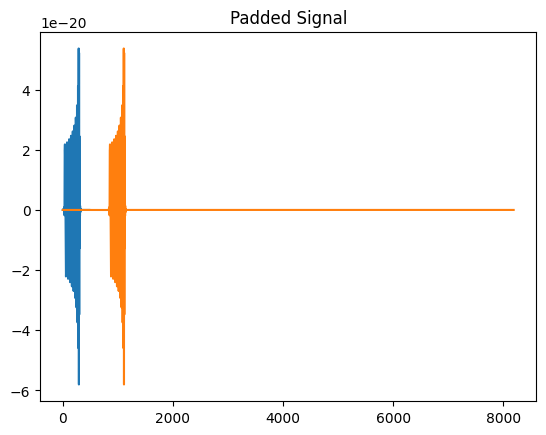

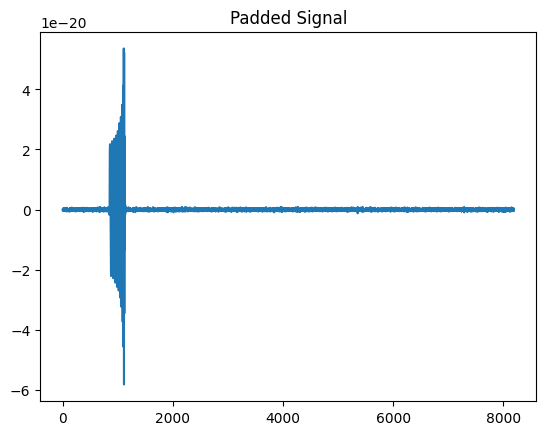

In [13]:
import torch
plt.plot(signal_l1)
signal = torch.zeros_like(ts[0])
starting_time = 0.2

timestamps = torch.arange(0, sample_duration, step = 1/4096)

signal[int(starting_time * 4096):int(starting_time * 4096) + len(signal_l1)] = Tensor(signal_l1)
print(signal.shape)
plt.title("Padded Signal")
plt.plot(signal)
plt.show()

plt.title("Padded Signal")
plt.plot(signal + noise)
plt.show()